#Word Embeddings

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time
from collections import defaultdict
import nltk
import spacy
import logging 
from string import punctuation
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
%matplotlib inline

In [2]:
con = sqlite3.connect("/content/Wayfair.db")

In [3]:
df = pd.read_sql("SELECT * FROM Comments", con)

In [4]:
df.head()

,author,comment,date,link,parent,submission,score,subreddit
0,Fratetrain91,I will probably never buy from Wayfair after r...,1.594256e+09,t3_hn78zr,hn78zr,hn78zr,3,wayfair
1,CySU,Reading this making me second guess our purcha...,1.594261e+09,t3_hn78zr,hn78zr,hn78zr,5,wayfair
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,1.594329e+09,t3_hn78zr,hn78zr,hn78zr,2,wayfair
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,1.594337e+09,t3_hn78zr,hn78zr,hn78zr,2,wayfair
4,Elysianfieldflower,I did handy installations for a little while b...,1.594501e+09,t3_hn78zr,hn78zr,hn78zr,1,wayfair


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75418 entries, 0 to 75417
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   author      72911 non-null  object 
 1   comment     75418 non-null  object 
 2   date        75418 non-null  float64
 3   link        75418 non-null  object 
 4   parent      75418 non-null  object 
 5   submission  75418 non-null  object 
 6   score       75418 non-null  int64  
 7   subreddit   75418 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.6+ MB


In [6]:
df['date']= pd.to_datetime(df['date'],unit='s')

In [7]:
df.head()

,author,comment,date,link,parent,submission,score,subreddit
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair


In [8]:
len(df)

75418

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser'])

In [ ]:
def cleaning_lem(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
t = time()
txt = [cleaning_lem(doc) for doc in nlp.pipe(df['comment'], batch_size=100, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.84 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(26106, 1)


                                               clean
0  probably buy Wayfair read   imagine feel know ...
1  read make second guess purchase order tv Enter...
2  thank warning sound awful look bedroom set sen...
3            caveat emptor buyer Beware proceed risk
4  handy installation little like uber let signnu...


In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=5, progress_per=1000)

INFO - 21:20:04: collecting all words and their counts
INFO - 21:20:04: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 21:20:05: PROGRESS: at sentence #1000, processed 15188 words and 15742 word types
INFO - 21:20:05: PROGRESS: at sentence #2000, processed 31154 words and 29201 word types
INFO - 21:20:05: PROGRESS: at sentence #3000, processed 48420 words and 42871 word types
INFO - 21:20:05: PROGRESS: at sentence #4000, processed 64851 words and 54919 word types
INFO - 21:20:05: PROGRESS: at sentence #5000, processed 81370 words and 67372 word types
INFO - 21:20:05: PROGRESS: at sentence #6000, processed 98541 words and 79353 word types
INFO - 21:20:05: PROGRESS: at sentence #7000, processed 113543 words and 89711 word types
INFO - 21:20:05: PROGRESS: at sentence #8000, processed 128863 words and 99642 word types
INFO - 21:20:05: PROGRESS: at sentence #9000, processed 144876 words and 110146 word types
INFO - 21:20:05: PROGRESS: at sentence #10000, processed 15975

In [ ]:
bigram = Phraser(phrases)

INFO - 21:21:29: source_vocab length 297483
INFO - 21:21:32: Phraser built with 1763 phrasegrams


In [ ]:
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

32090

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['people',
 'like',
 'think',
 'Wayfair',
 'know',
 'thing',
 'say',
 'go',
 'name',
 'child']

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()
cores

2

In [ ]:
w2v_model = Word2Vec(min_count=5,
                     window=20,
                     size=100,  
                     negative=10,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:24:56: collecting all words and their counts
INFO - 21:24:56: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:24:56: PROGRESS: at sentence #1000, processed 13907 words, keeping 3902 word types
INFO - 21:24:56: PROGRESS: at sentence #2000, processed 28606 words, keeping 5912 word types
INFO - 21:24:56: PROGRESS: at sentence #3000, processed 44517 words, keeping 7793 word types
INFO - 21:24:56: PROGRESS: at sentence #4000, processed 59719 words, keeping 9075 word types
INFO - 21:24:57: PROGRESS: at sentence #5000, processed 74982 words, keeping 10579 word types
INFO - 21:24:57: PROGRESS: at sentence #6000, processed 90743 words, keeping 11804 word types
INFO - 21:24:57: PROGRESS: at sentence #7000, processed 104619 words, keeping 12890 word types
INFO - 21:24:57: PROGRESS: at sentence #8000, processed 118682 words, keeping 13833 word types
INFO - 21:24:57: PROGRESS: at sentence #9000, processed 133609 words, keeping 14774 word types
INFO - 21:24:57: 

Time to build vocab: 0.05 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:25:28: training model with 1 workers on 7883 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10 window=20
INFO - 21:25:29: EPOCH 1 - PROGRESS: at 41.32% examples, 136297 words/s, in_qsize 1, out_qsize 0
INFO - 21:25:30: EPOCH 1 - PROGRESS: at 77.59% examples, 128611 words/s, in_qsize 2, out_qsize 0
INFO - 21:25:30: worker thread finished; awaiting finish of 0 more threads
INFO - 21:25:30: EPOCH - 1 : training on 412442 raw words (349146 effective words) took 2.5s, 137990 effective words/s
INFO - 21:25:31: EPOCH 2 - PROGRESS: at 43.78% examples, 138961 words/s, in_qsize 1, out_qsize 0
INFO - 21:25:32: EPOCH 2 - PROGRESS: at 86.16% examples, 143716 words/s, in_qsize 1, out_qsize 0
INFO - 21:25:33: worker thread finished; awaiting finish of 0 more threads
INFO - 21:25:33: EPOCH - 2 : training on 412442 raw words (349103 effective words) took 2.4s, 148065 effective words/s
INFO - 21:25:34: EPOCH 3 - PROGRESS: at 43.78% examples, 138992 words/s, in_qsize 1, out_

Time to train the model: 1.19 mins


In [ ]:
w2v_model.init_sims(replace=True)

INFO - 21:28:47: precomputing L2-norms of word weight vectors


In [ ]:
similar_words = {search_term: [item for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['Wayfair', 'children', 'democrat','media', 'closet','pedophile','qanon','Clinton','Epstein','sex']}

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
pd.DataFrame(similar_words)

,Wayfair,children,democrat,media,closet,pedophile,qanon,Clinton,Epstein,sex
0,"(marketplace, 0.49184533953666687)","(production, 0.5245946645736694)","(Seth, 0.7352807521820068)","(medium, 0.6839147806167603)","(super_expensive, 0.5852577090263367)","(satanic, 0.5927447080612183)","(propagate, 0.6406214833259583)","(Clintons, 0.6783139705657959)","(Jeffrey_Epstein, 0.714432954788208)","(groom, 0.6854678988456726)"
1,"(home_good, 0.4690198004245758)","(middle, 0.4920414388179779)","(conservative, 0.7301881909370422)","(desensitize, 0.6154801845550537)","(locker, 0.5387449264526367)","(pedophilia, 0.5488631129264832)","(right_wing, 0.636306881904602)","(Hilary, 0.6776108741760254)","(Prince_Andrew, 0.7080237865447998)","(prostitution, 0.6547490954399109)"
2,"(Wayfair_employee, 0.4579553008079529)","(labeling, 0.478680282831192)","(democrats, 0.7162036895751953)","(pizzagate, 0.5979244709014893)","(Ikea, 0.5261043310165405)","(heinous, 0.5237893462181091)","(batshit, 0.6065154671669006)","(Hillary_Clinton, 0.6628488302230835)","(Epstein_Maxwell, 0.6727718114852905)","(vulnerable, 0.6460639238357544)"
3,"(retail, 0.43782007694244385)","(neglect, 0.47557953000068665)","(presidency, 0.7111460566520691)","(hoax, 0.595669150352478)","(cupboard, 0.5113333463668823)","(coverup, 0.5159045457839966)","(promote, 0.5979441404342651)","(pizza_place, 0.6292223930358887)","(Maxwell, 0.6569803357124329)","(prostitute, 0.6309060454368591)"
4,"(party_seller, 0.43560534715652466)","(dimension, 0.4734337627887726)","(republican, 0.707600474357605)","(fake_news, 0.5851050615310669)","(9k, 0.508880615234375)","(secret, 0.5073723793029785)","(4chan, 0.5965983867645264)","(Biden, 0.6266555190086365)","(Bill_Clinton, 0.6444016098976135)","(lure, 0.6159986853599548)"


In [ ]:
model_wayfair = "w2v_model"
w2v_model.save(model_wayfair)

INFO - 02:55:38: saving Word2Vec object under w2v_model, separately None
INFO - 02:55:38: not storing attribute vectors_norm
INFO - 02:55:38: not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 02:55:38: saved w2v_model


In [ ]:
model_wayfair = "w2v_model"
model_wayfair = Word2Vec.load(model_wayfair)

#Topic Models

In [9]:
bool_df = df['comment'].duplicated(keep='first')
df_unique = df[~bool_df]
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29981 entries, 0 to 32259
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   author      29727 non-null  object        
 1   comment     29981 non-null  object        
 2   date        29981 non-null  datetime64[ns]
 3   link        29981 non-null  object        
 4   parent      29981 non-null  object        
 5   submission  29981 non-null  object        
 6   score       29981 non-null  int64         
 7   subreddit   29981 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.1+ MB


In [ ]:
df_unique['index'] = np.arange(len(df_unique))

In [11]:
df_unique.head()

,author,comment,date,link,parent,submission,score,subreddit,index
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair,0
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair,1
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair,2
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair,3
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair,4


In [12]:
def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = re.sub(r'pic.twitter\S+','',text)
    text = text.strip('[link]') # remove [links]
    return text

In [ ]:
df_unique['text'] = df_unique['comment'].apply(remove_links)

In [14]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')


tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
def pre_process(text):
  temp1 = ''.join(word for word in text if not word.isdigit())
  temp2 = tokenizer.tokenize(temp1)
  temp3 = [word.lower() for word in temp2 if word.lower() not in stopwords.words('english')]
  return temp3

In [16]:
t = time()
df_unique['text'] = df_unique['text'].apply(pre_process)
print('Time to process text: {} mins'.format(round((time() - t) / 60, 2)))

Time to process text: 1.61 mins


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df_unique['text'].iloc[4]

['handy',
 'installations',
 'little',
 'like',
 'uber',
 'let',
 'anyone',
 'signnup',
 'tell',
 'many',
 'people',
 'similar',
 'story',
 'many',
 'people',
 'second',
 'even',
 'third',
 'person',
 'go',
 'try',
 'fix',
 'someone',
 'else',
 'fuckup',
 'persons',
 'story',
 'even',
 'uncommon',
 'wayfair',
 'handy',
 'complete',
 'garbage',
 'issue',
 'noone',
 'take',
 'responsibility',
 'everything',
 'contracted',
 'someone',
 'else',
 'broken',
 'oh',
 'delivery',
 'company',
 'problem',
 'drilled',
 'right',
 'go',
 'contact',
 'manufacturer',
 'installer',
 'issues',
 'talk',
 'wayfair',
 'handy',
 'hired',
 'contractor',
 'garbage']

In [19]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
phrases = Phrases(df_unique['text'], min_count=20, threshold=100)
bigram = Phraser(phrases)

INFO - 12:53:29: 'pattern' package not found; tag filters are not available for English
INFO - 12:53:29: collecting all words and their counts
INFO - 12:53:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 12:53:30: PROGRESS: at sentence #10000, processed 161002 words and 125206 word types
INFO - 12:53:30: PROGRESS: at sentence #20000, processed 320166 words and 227862 word types
INFO - 12:53:30: collected 339338 word types from a corpus of 500125 words (unigram + bigrams) and 29981 sentences
INFO - 12:53:30: using 339338 counts as vocab in Phrases<0 vocab, min_count=20, threshold=100, max_vocab_size=40000000>
INFO - 12:53:30: source_vocab length 339338
INFO - 12:53:33: Phraser built with 129 phrasegrams


In [ ]:
df_unique['text_clean'] = bigram[df_unique['text']]

In [21]:
df_unique['text_clean'].iloc[4]

['handy',
 'installations',
 'little',
 'like',
 'uber',
 'let',
 'anyone',
 'signnup',
 'tell',
 'many',
 'people',
 'similar',
 'story',
 'many',
 'people',
 'second',
 'even',
 'third',
 'person',
 'go',
 'try',
 'fix',
 'someone',
 'else',
 'fuckup',
 'persons',
 'story',
 'even',
 'uncommon',
 'wayfair',
 'handy',
 'complete',
 'garbage',
 'issue',
 'noone',
 'take',
 'responsibility',
 'everything',
 'contracted',
 'someone',
 'else',
 'broken',
 'oh',
 'delivery',
 'company',
 'problem',
 'drilled',
 'right',
 'go',
 'contact',
 'manufacturer',
 'installer',
 'issues',
 'talk',
 'wayfair',
 'handy',
 'hired',
 'contractor',
 'garbage']

In [22]:
len(df_unique)

29981

In [23]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

INFO - 12:53:56: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 12:53:56: built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [24]:
common_dictionary = Dictionary(df_unique['text_clean'])
common_corpus = [common_dictionary.doc2bow(text) for text in df_unique['text_clean']]

INFO - 12:53:59: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 12:53:59: adding document #10000 to Dictionary(13487 unique tokens: ['aggressive', 'buy', 'capable', 'disappointing', 'feeling']...)
INFO - 12:54:00: adding document #20000 to Dictionary(19717 unique tokens: ['aggressive', 'buy', 'capable', 'disappointing', 'feeling']...)
INFO - 12:54:00: built Dictionary(27219 unique tokens: ['aggressive', 'buy', 'capable', 'disappointing', 'feeling']...) from 29981 documents (total 493142 corpus positions)


In [34]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
#from gensim.models.wrappers import LdaMallet

In [ ]:
#import os       #importing os to set environment variable
#def install_java():
#  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
#  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
#  !java -version       #check java version
#install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#!unzip mallet-2.0.8.zip

In [ ]:
#import zipfile
#from google.colab import files

#uploaded = files.upload()

Saving mallet-2.0.8.zip to mallet-2.0.8 (1).zip


In [ ]:
#path_to_zip_file = list(uploaded.keys())[0]

#print ('Extracting',path_to_zip_file)

#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall('.')

#print()
#print('Here is a directory listing (you should see a directory with your corpus):')
#!ls -l

Extracting mallet-2.0.8.zip

Here is a directory listing (you should see a directory with your corpus):
total 53192
drwxr-xr-x 10 root root     4096 Nov 14  2016  mallet-2.0.8
-rw-r--r--  1 root root 16184794 Sep  6 15:44 'mallet-2.0.8 (1).zip'
-rw-r--r--  1 root root 16184794 Nov 14  2016  mallet-2.0.8.zip
drwxr-xr-x  1 root root     4096 Aug 27 16:39  sample_data
-rw-r--r--  1 root root 22085632 Sep  6 13:41  Wayfair.db


In [ ]:
#os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
#mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [65]:
%%capture
def compute_coherence_values(dictionary, corpus, texts, alpha_test, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    perplexity_values= []
    for alpha in alpha_test:
      temp_coherence = []
      temp_model = []
      temp_perplexity = []
      for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, alpha=alpha,id2word=dictionary)
        #model = LdaMallet(mallet_path, corpus=corpus,
                          #num_topics=num_topics, id2word=common_dictionary,
                          #alpha=alpha)
        temp_model.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        temp_coherence.append(coherencemodel.get_coherence())
        temp_perplexity.append(model.log_perplexity(common_corpus))
      coherence_values.append(temp_coherence)
      model_list.append(temp_model)
      perplexity_values.append(temp_perplexity)

    return model_list, coherence_values, perplexity_values

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, alpha_test, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    #coherence_values = []
    #model_list = []
    perplexity_values= []
    for alpha in alpha_test:
      #temp_coherence = []
      #temp_model = []
      temp_perplexity = []
      #val_scores = []
      for num_topics in range(start, limit, step):
        #temp2_coherence = []
        temp2_perplexity = []
        for fold in range(k):
          val_data = corpus[num_val_samples * fold: num_val_samples * (fold + 1)]
          training_data = corpus[:num_val_samples * fold] + corpus[num_val_samples * (fold + 1)]
          training_dict = id2word[:num_val_samples_dict * fold] + id2word[num_val_samples_dict * (fold + 1)]
          model = LdaModel(corpus=training_data, num_topics=num_topics, alpha=alpha,id2word=training_dict)
          #model = LdaMallet(mallet_path, corpus=corpus,
                          #num_topics=num_topics, id2word=common_dictionary,
                          #alpha=alpha)
          #temp_model.append(model)
          #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=training_dict, coherence='c_v')
          #temp2_coherence.append(coherencemodel.get_coherence())
          temp2_perplexity.append(model.log_perplexity(val_data))
        #temp_coherence.append(temp2_coherence)
        temp_perplexity(np.average(temp2_perplexity))
      #coherence_values.append(temp_coherence)
      #model_list.append(temp_model)
      perplexity_values.append(np.average(temp_perplexity)
      
    #return model_list, coherence_values, perplexity_values
    return perplexity_values

In [66]:
t = time()
k = 5
num_val_samples = len(common_corpus) // k
num_val_samples_dict = len(common_dictionary) // k
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=common_dictionary, 
                                                        corpus=common_corpus, texts=df_unique['text_clean'],
                                                        alpha_test=[0.01,0.03,0.05,0.1,0.3,0.5], 
                                                        start=10, limit=110, step=10)
print('Time to check different models: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:09:29: topic #5 (0.300): 0.054*"stop" + 0.046*"ago" + 0.034*"months" + 0.032*"related" + 0.031*"known" + 0.027*"figure" + 0.025*"also" + 0.025*"original" + 0.024*"lost" + 0.023*"drugs"
INFO - 14:09:29: topic #37 (0.300): 0.056*"story" + 0.054*"ok" + 0.053*"account" + 0.037*"friends" + 0.031*"bunch" + 0.023*"perhaps" + 0.023*"result" + 0.021*"create" + 0.019*"simply" + 0.018*"idiot"
INFO - 14:09:29: topic #4 (0.300): 0.094*"found" + 0.080*"search" + 0.049*"twitter" + 0.049*"google" + 0.039*"yandex" + 0.033*"op" + 0.033*"find" + 0.031*"images" + 0.029*"edit" + 0.022*"history"
INFO - 14:09:29: topic #55 (0.300): 0.084*"fuck" + 0.040*"people" + 0.039*"honestly" + 0.034*"clearly" + 0.022*"anything" + 0.022*"opinion" + 0.018*"argument" + 0.016*"anyway" + 0.016*"even" + 0.016*"checked"
INFO - 14:09:29: topic #16 (0.300): 0.074*"item" + 0.060*"stock" + 0.056*"kind" + 0.042*"came" + 0.041*"put" + 0.040*"one" + 0.038*"listing" + 0.026*"tried" + 0.023*"however" + 0.023*"suspicious"
INFO

In [67]:
print(len(coherence_values))
print(len(perplexity_values))

6
6


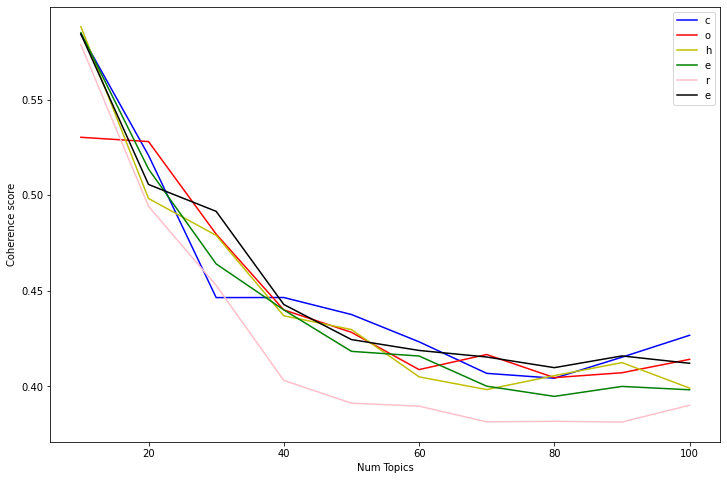

In [68]:
import matplotlib.pyplot as plt

limit=110; start=10; step=10;
x = range(start, limit, step)
plt.figure(figsize=(12,8))
plt.plot(x, coherence_values[0],'b')
plt.plot(x, coherence_values[1],'r')
plt.plot(x, coherence_values[2],'y')
plt.plot(x, coherence_values[3],'g')
plt.plot(x, coherence_values[4],'pink')
plt.plot(x, coherence_values[5],'black')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

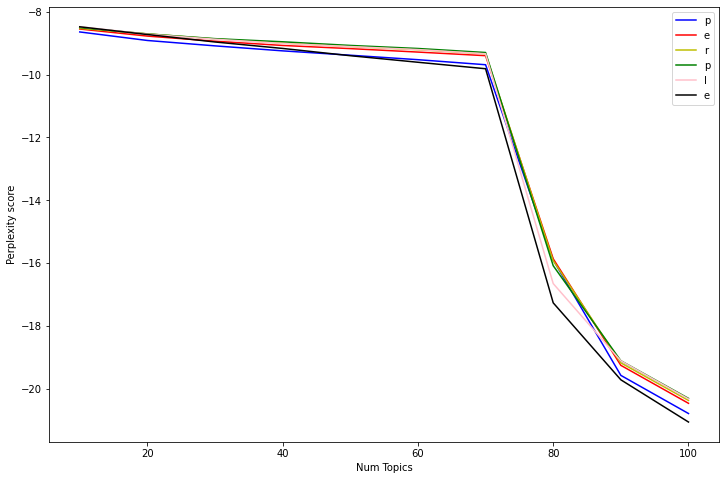

In [69]:
limit=110; start=10; step=10;
x = range(start, limit, step)
plt.figure(figsize=(12,8))
plt.plot(x, perplexity_values[0],'b')
plt.plot(x, perplexity_values[1],'r')
plt.plot(x, perplexity_values[2],'y')
plt.plot(x, perplexity_values[3],'g')
plt.plot(x, perplexity_values[4],'pink')
plt.plot(x, perplexity_values[5],'black')
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [70]:
for m, cv in zip(x, coherence_values[2]):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5881
Num Topics = 20  has Coherence Value of 0.4982
Num Topics = 30  has Coherence Value of 0.479
Num Topics = 40  has Coherence Value of 0.437
Num Topics = 50  has Coherence Value of 0.4298
Num Topics = 60  has Coherence Value of 0.405
Num Topics = 70  has Coherence Value of 0.3984
Num Topics = 80  has Coherence Value of 0.4057
Num Topics = 90  has Coherence Value of 0.4125
Num Topics = 100  has Coherence Value of 0.3992


In [71]:
for m, cv in zip(x, perplexity_values[2]):
    print("Num Topics =", m, " has Perplexity Value of", round(2**-(cv), 4))

Num Topics = 10  has Perplexity Value of 368.3659
Num Topics = 20  has Perplexity Value of 415.768
Num Topics = 30  has Perplexity Value of 465.1196
Num Topics = 40  has Perplexity Value of 509.9044
Num Topics = 50  has Perplexity Value of 550.8375
Num Topics = 60  has Perplexity Value of 590.3304
Num Topics = 70  has Perplexity Value of 645.2973
Num Topics = 80  has Perplexity Value of 62172.0448
Num Topics = 90  has Perplexity Value of 593707.2377
Num Topics = 100  has Perplexity Value of 1359643.617


In [74]:
lda = LdaModel(common_corpus, id2word=common_dictionary, num_topics=10,alpha=0.03)

INFO - 15:35:30: using symmetric eta at 0.1
INFO - 15:35:30: using serial LDA version on this node
INFO - 15:35:30: running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 29981 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO - 15:35:30: PROGRESS: pass 0, at document #2000/29981
INFO - 15:35:31: merging changes from 2000 documents into a model of 29981 documents
INFO - 15:35:31: topic #4 (0.030): 0.010*"wayfair" + 0.008*"missing" + 0.007*"like" + 0.007*"names" + 0.006*"child" + 0.006*"name" + 0.006*"kids" + 0.005*"even" + 0.005*"find" + 0.005*"would"
INFO - 15:35:31: topic #1 (0.030): 0.011*"people" + 0.007*"something" + 0.006*"like" + 0.006*"sure" + 0.005*"k" + 0.005*"wayfair" + 0.004*"really" + 0.004*"right" + 0.004*"find" + 0.004*"names"
INFO - 15:35:31: topic #9 (0.030): 0.013*"people" + 0.012*"like" + 0.009*"think" + 0.008*"wayfair" + 0.0

In [ ]:
from gensim.test.utils import datapath
temp_file = datapath("/content/model_lda_10k")
lda.save(temp_file)

INFO - 21:55:01: saving LdaState object under /content/model_lda_10k.state, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
INFO - 21:55:01: saved /content/model_lda_10k.state
INFO - 21:55:01: saving LdaModel object under /content/model_lda_10k, separately ['expElogbeta', 'sstats']
INFO - 21:55:01: storing np array 'expElogbeta' to /content/model_lda_10k.expElogbeta.npy
INFO - 21:55:01: not storing attribute dispatcher
INFO - 21:55:01: not storing attribute state
INFO - 21:55:01: not storing attribute id2word
INFO - 21:55:01: saved /content/model_lda_10k


In [75]:
print(lda.print_topics())

INFO - 15:35:46: topic #0 (0.030): 0.042*"missing" + 0.019*"names" + 0.017*"name" + 0.013*"children" + 0.011*"people" + 0.010*"found" + 0.008*"one" + 0.008*"kids" + 0.007*"girl" + 0.007*"year"
INFO - 15:35:46: topic #1 (0.030): 0.015*"link" + 0.012*"r" + 0.011*"post" + 0.008*"yandex" + 0.008*"removed" + 0.007*"message_compose" + 0.007*"please_contact" + 0.007*"questions_concerns" + 0.006*"bot_action" + 0.006*"performed_automatically"
INFO - 15:35:46: topic #2 (0.030): 0.020*"people" + 0.018*"trafficking" + 0.013*"think" + 0.012*"like" + 0.010*"child" + 0.010*"wayfair" + 0.010*"know" + 0.008*"would" + 0.008*"human" + 0.007*"sex"
INFO - 15:35:46: topic #3 (0.030): 0.015*"would" + 0.012*"money" + 0.011*"get" + 0.009*"way" + 0.007*"even" + 0.007*"one" + 0.007*"like" + 0.007*"make" + 0.006*"kid" + 0.006*"wayfair"
INFO - 15:35:46: topic #4 (0.030): 0.008*"wayfair" + 0.006*"thanks" + 0.005*"like" + 0.005*"ok" + 0.005*"good" + 0.004*"bro" + 0.004*"even" + 0.004*"man" + 0.004*"friends" + 0.004*

[(0, '0.042*"missing" + 0.019*"names" + 0.017*"name" + 0.013*"children" + 0.011*"people" + 0.010*"found" + 0.008*"one" + 0.008*"kids" + 0.007*"girl" + 0.007*"year"'), (1, '0.015*"link" + 0.012*"r" + 0.011*"post" + 0.008*"yandex" + 0.008*"removed" + 0.007*"message_compose" + 0.007*"please_contact" + 0.007*"questions_concerns" + 0.006*"bot_action" + 0.006*"performed_automatically"'), (2, '0.020*"people" + 0.018*"trafficking" + 0.013*"think" + 0.012*"like" + 0.010*"child" + 0.010*"wayfair" + 0.010*"know" + 0.008*"would" + 0.008*"human" + 0.007*"sex"'), (3, '0.015*"would" + 0.012*"money" + 0.011*"get" + 0.009*"way" + 0.007*"even" + 0.007*"one" + 0.007*"like" + 0.007*"make" + 0.006*"kid" + 0.006*"wayfair"'), (4, '0.008*"wayfair" + 0.006*"thanks" + 0.005*"like" + 0.005*"ok" + 0.005*"good" + 0.004*"bro" + 0.004*"even" + 0.004*"man" + 0.004*"friends" + 0.004*"thread"'), (5, '0.008*"baby" + 0.008*"thank" + 0.007*"oh" + 0.006*"u" + 0.006*"wtf" + 0.005*"photo" + 0.005*"yes" + 0.005*"one" + 0.004*

In [76]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [ ]:
t = time()
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=df_unique['text_clean'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

print('Time to show topics: {} mins'.format(round((time() - t) / 60, 2)))

In [80]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.6848,"snopes, said, one, true, never, false, really,...","[probably, never, buy, wayfair, reading, imagi..."
1,1,5.0,0.9182,"baby, thank, oh, u, wtf, photo, yes, one, arti...","[reading, making, second, guess, purchase, ord..."
2,2,5.0,0.5652,"baby, thank, oh, u, wtf, photo, yes, one, arti...","[thanks, warning, sound, awful, looking, bedro..."
3,3,9.0,0.9780,"people, like, conspiracy, think, post, know, s...","[caveat, emptor, buyer, beware, proceed, risk]"
4,4,8.0,0.8977,"like, one, could, would, wayfair, looks, also,...","[handy, installations, little, like, uber, let..."
5,5,9.0,0.9372,"people, like, conspiracy, think, post, know, s...","[specialize, furniture]"
6,6,9.0,0.8803,"people, like, conspiracy, think, post, know, s...","[sorry, hear, went, absurd, concerned, safety,..."
7,7,6.0,0.9844,"wayfair, names, price, items, would, cabinets,...","[cancel, like, buy, something, elsewhere, wayf..."
8,8,3.0,0.3215,"would, money, get, way, even, one, like, make,...","[thanks, note, completely, understand, degree,..."
9,9,0.0,0.8489,"missing, names, name, children, people, found,...","[another, wayfair, delivery, made, put, first,..."


In [81]:
len(df_dominant_topic)

32050

In [82]:
df7 = df_dominant_topic[df_dominant_topic['Dominant_Topic']==7]

In [83]:
df7.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.6848,"snopes, said, one, true, never, false, really,...","[probably, never, buy, wayfair, reading, imagi..."
14,14,7.0,0.3951,"snopes, said, one, true, never, false, really,...","[nope, threat, going, stand, intimidation, nei..."
18,18,7.0,0.8033,"snopes, said, one, true, never, false, really,...","[please, also, use]"
24,24,7.0,0.7923,"snopes, said, one, true, never, false, really,...","[yeah, true, stupid, scammers]"
50,50,7.0,0.5250,"snopes, said, one, true, never, false, really,...","[sometimes, though, exact, shelf, k, price, di..."


In [84]:
df7.sort_values(by=['Topic_Perc_Contrib'])['Text'].iloc[:50]

25268    [oh, sorry, saying, specifically, saying, gene...
13564                                                  NaN
15383    [make, cash, check, deposit, one, transaction,...
18242    [thinking, know, real, buyer, sort, pass, code...
477                                   [wayfair, got, need]
27290    [believe, pizzagate, conspiracy, freaks, still...
10206    [yeah, know, right, spitballing, maybe, real, ...
6468     [mention, sears, beneficial, african, american...
3104                                [looks, like, removed]
13498                                               [link]
4381        [wild, heard, spreading, twitter, use, tiktok]
26634    [op, leave, sub, like, need, stupid, cancel, c...
20458    [aj, draws, parallel, comet, pizzagate, wayfai...
9152     [fuck, sake, people, dumb, wayfair, used, laun...
20863    [think, people, believe, shit, probably, type,...
17972              [convert, dollar, amounts, coordinates]
11249    [ok, dark_web, bitcoin, compromised, selling, .

In [ ]:
df_unique['text'] = df_unique['comment'].apply(remove_links)

In [86]:
df_unique.head()

,author,comment,date,link,parent,submission,score,subreddit,index,text,text_clean
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair,0,I will probably never buy from Wayfair after r...,"[probably, never, buy, wayfair, reading, imagi..."
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair,1,Reading this making me second guess our purcha...,"[reading, making, second, guess, purchase, ord..."
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair,2,Thanks for the warning! They sound awful! We w...,"[thanks, warning, sound, awful, looking, bedro..."
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair,3,‘Caveat Emptor’. Buyer Beware. Proceed at your...,"[caveat, emptor, buyer, beware, proceed, risk]"
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair,4,I did handy installations for a little while b...,"[handy, installations, little, like, uber, let..."


In [87]:
t = time()
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer(analyzer=pre_process, max_df=0.95, min_df=0.01)
print('Vectorizer Created')
data = vectoriser.fit_transform(df_unique['text'])
print('Data Created')
features = vectoriser.get_feature_names()
print('Features Created')
print('Time to vectorise and create features: {} mins'.format(round((time() - t) / 60, 2)))

Vectorizer Created
Data Created
Features Created
Time to vectorise and create features: 1.61 mins


In [88]:
from sklearn.model_selection import GridSearchCV 
# Define Search Param
search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100], 'doc_topic_prior': [0.01, 0.03, 0.05, 0.1, 0.2]}
#search_params = {'n_components': [10,20,30,40,50,60,70,80,90,100]}

In [89]:
t = time()
class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # add perplexity to the cross-validation
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X,sub_sampling=True)

        # turn perplexity into a negative number
        return -1*score
        
lda = MyLDAWithPerplexityScorer(max_iter=5, learning_method='online', learning_offset=50.,
                                random_state=1983,verbose=1)
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1,cv=5,refit = True,verbose=1)
model.fit(data)
print('Time to finish cross-validation: {} mins'.format(round((time() - t) / 60, 2)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 61.7min finished


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
Time to finish cross-validation: 62.02 mins


In [90]:
cv = pd.DataFrame(model.cv_results_)

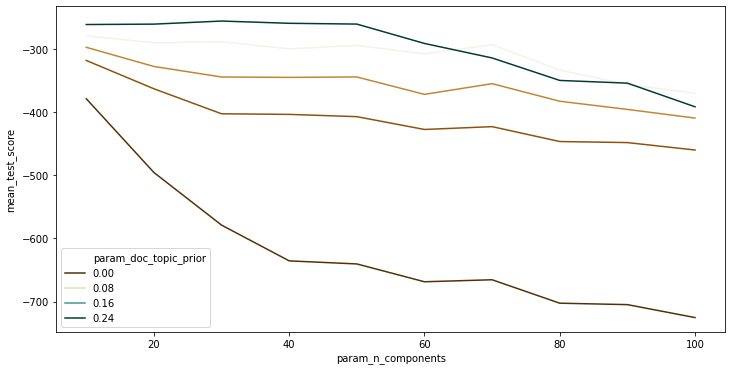

In [91]:
plt.figure(figsize=(12,6))
sns.lineplot(x="param_n_components", y="mean_test_score", data=cv,hue='param_doc_topic_prior',palette='BrBG')

In [92]:
cv_alpha = cv[cv['param_doc_topic_prior'] == 0.01]

In [ ]:
pip install kneed

In [94]:
from kneed import KneeLocator
k = cv_alpha['param_n_components']
per = cv_alpha['mean_test_score']
k = pd.to_numeric(k)
per = pd.to_numeric(per)
kn = KneeLocator(k, per, curve='convex', direction='decreasing')
kn.knee

40

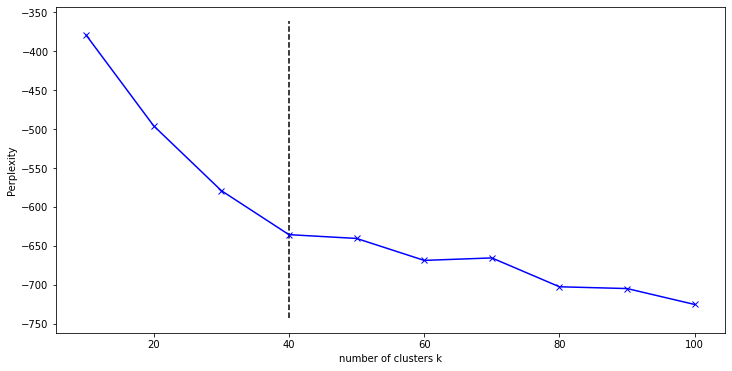

In [95]:
plt.figure(figsize=(12,6))
plt.xlabel('number of clusters k')
plt.ylabel('Perplexity')
plt.plot(k, per, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [96]:
lda_model = LatentDirichletAllocation(doc_topic_prior = 0.01, learning_method='online',n_components=40,n_jobs=-1,verbose=1,random_state = 1983)
lda_output = lda_model.fit_transform(data)
print(lda_model)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.01,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=-1,
                          perp_tol=0.1, random_state=1983,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)


In [97]:
theta = pd.DataFrame(lda_output)
theta['index'] = np.arange(len(theta))
theta.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,index
0,0.001064,0.001064,0.001064,0.107447,0.001064,0.001064,0.107447,0.001064,0.107447,0.001064,0.113161,0.001064,0.001064,0.112877,0.001064,0.107447,0.001064,0.001064,0.001064,0.001064,0.309068,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0
1,0.000877,0.000877,0.000877,0.088596,0.088596,0.000877,0.176316,0.088596,0.088596,0.000877,0.000877,0.000877,0.000877,0.088596,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.088596,0.176316,0.088596,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,1
2,0.001563,0.001563,0.001563,0.157812,0.001563,0.001563,0.157813,0.001563,0.157812,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157813,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157813,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157812,2
3,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3
4,0.000352,0.000352,0.000352,0.000352,0.000352,0.659457,0.074213,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.035567,0.035551,0.000352,0.035563,0.000352,0.000352,0.000352,0.000352,0.050919,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.097110,0.000352,0.000352,0.000352,0.000352,0.000352,4


In [98]:
meta_theta_df = df_unique.join(theta, how='left', on='index', rsuffix = '_theta')

In [99]:
pd.options.display.max_columns = None
meta_theta_df.head()

,author,comment,date,link,parent,submission,score,subreddit,index,text,text_clean,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,index_theta
0,Fratetrain91,I will probably never buy from Wayfair after r...,2020-07-09 00:50:19,t3_hn78zr,hn78zr,hn78zr,3,wayfair,0,I will probably never buy from Wayfair after r...,"[probably, never, buy, wayfair, reading, imagi...",0.001064,0.001064,0.001064,0.107447,0.001064,0.001064,0.107447,0.001064,0.107447,0.001064,0.113161,0.001064,0.001064,0.112877,0.001064,0.107447,0.001064,0.001064,0.001064,0.001064,0.309068,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0.001064,0
1,CySU,Reading this making me second guess our purcha...,2020-07-09 02:24:20,t3_hn78zr,hn78zr,hn78zr,5,wayfair,1,Reading this making me second guess our purcha...,"[reading, making, second, guess, purchase, ord...",0.000877,0.000877,0.000877,0.088596,0.088596,0.000877,0.176316,0.088596,0.088596,0.000877,0.000877,0.000877,0.000877,0.088596,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.088596,0.176316,0.088596,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,0.000877,1
2,PerelandraNative,Thanks for the warning! They sound awful! We w...,2020-07-09 21:18:11,t3_hn78zr,hn78zr,hn78zr,2,wayfair,2,Thanks for the warning! They sound awful! We w...,"[thanks, warning, sound, awful, looking, bedro...",0.001563,0.001563,0.001563,0.157812,0.001563,0.001563,0.157813,0.001563,0.157812,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157813,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157813,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.001563,0.157812,2
3,cooljay790,‘Caveat Emptor’. Buyer Beware. Proceed at your...,2020-07-09 23:24:28,t3_hn78zr,hn78zr,hn78zr,2,wayfair,3,‘Caveat Emptor’. Buyer Beware. Proceed at your...,"[caveat, emptor, buyer, beware, proceed, risk]",0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3
4,Elysianfieldflower,I did handy installations for a little while b...,2020-07-11 20:48:41,t3_hn78zr,hn78zr,hn78zr,1,wayfair,4,I did handy installations for a little while b...,"[handy, installations, little, like, uber, let...",0.000352,0.000352,0.000352,0.000352,0.000352,0.659457,0.074213,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.035567,0.035551,0.000352,0.035563,0.000352,0.000352,0.000352,0.000352,0.050919,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.097110,0.000352,0.000352,0.000352,0.000352,0.000352,4


In [100]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
#mybeta = np.exp(mybeta)

In [101]:
nwords = 50

topwords = []
for i in range(0,40,1):
  tempframe = mybeta[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwords.append(tempframe.index.values)

topwords = pd.DataFrame(topwords).T
topwords.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,site,work,way,never,order,someone,something,please,may,sure,true,cabinets,sex,right,items,names,item,lot,truth,even,probably,going,website,thought,search,though,much,evidence,crazy,actual,got,theory,end,us,fucking,child,sub,say,nothing,anything
1,product,trump,would,whole,least,go,like,kid,r,pretty,seems,point,seen,time,different,kids,keep,link,instead,actually,first,many,made,another,fuck,years,back,epstein,code,around,fact,laundering,girl,maybe,person,human,reddit,things,selling,children
2,wayfair,world,said,put,shipping,company,makes,comment,information,people,like,pillows,case,money,little,children,wrong,getting,explain,need,cabinet,oh,already,since,part,last,come,snopes,web,high,media,called,understand,lol,new,video,exactly,literally,went,looking
3,enough,using,expensive,everyone,business,everything,sense,making,edit,sell,yes,industrial,idea,stuff,girls,named,let,might,happens,would,make,definitely,news,seem,google,thinking,maxwell,internet,saw,ago,talking,theories,done,anyone,kind,day,prices,take,show,found
4,amazon,people,always,ever,bad,even,guys,place,listings,stupid,feel,pillow,overpriced,used,random,year,big,likely,number,stop,proof,anyone,without,two,help,great,like,pizzagate,agree,stock,suspicious,page,away,edit,try,involved,better,every,stock,interesting


In [102]:
text_theta = theta.join(df_unique['comment'], how='right',on='index')
text_theta = text_theta.set_index('comment')

In [103]:
ntext = 30

#index = np.arange(0,30,1)
#toptexts = pd.DataFrame(index,columns = ['index'])
toptexts=[]
for i in range(0,40,1):
  tempframe = text_theta.sort_values(i,ascending=False)
  tempframe = tempframe[1:ntext]
  #tempframe = tempframe['text']
  toptexts.append(tempframe.index.values)
  #tempframe = tempframe.reset_index()
  #toptexts = toptexts.join(tempframe['text'],on='index', lsuffix=i)

toptexts = pd.DataFrame(toptexts).T

toptexts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,Are missing persons the same as kidnapped pers...,I’ve never known what Wayfair was until a few ...,Is MAP not common code for Minor-Attracted Per...,Not the same. Illegible in photo.,This bullshit is some stovepiped crap designed...,Keep em coming guys. This gets more and more i...,No they don’t you fucking retard.,Her little arms must get tired from spinning.,I think it would make grammatical sense but ye...,I didn't post anything without researching it ...,Found another one. [https://www.wayfair.com/de...,> I study at a top University and have a futur...,Surelyyou'rejoking.jpeg,"The comments on here.. wow.. you all, just yes...",Takes one to know one,Some one else said maybe it’s media content th...,It’s because they don’t specialize in furnitur...,^ relevant username,"I somehow doubt that, what with the being dead...",On the floor under that white vase thing is a ...,No. It's a 1200 pound steel cabinet. That's he...,I literally just now found in a different post...,Do we know what the discord server for this?,Freedom.\n\nI never masturbated in my life. I ...,IF this is a leak then they’re doing a piss po...,where have you seen that a girl has come forwa...,“Let’s get our kids swiftly to market”\n- Joe ...,Snopes is such a joke.,It's not meant to be luxury. The only luxury p...,Post at #pedogate #pedowood on twitter,"Again, this isn't a shitposting site for karma...",Genau so ist es!,“ prepare for ... the worst. on society. to ...,and when you search the code thing it shows im...,PEOPLE OVER THERE WHATS UP,Who’s rich enough on reddit to buy this to see...,I'm new here so maybe this is stupid to ask. B...,AJ & Snopes doing their thing.,"Isn't it possible the theory ""Wayfair"" is traf...",So Wayfair saying the prices were glitched. \...
1,It's like you've never heard of industrial gra...,Great video,Why would there be an ottoman? There’s not on...,Did you try the coordinates in the other pattern?,"That’s crazy, I wish I took a screenshot",No ones suggesting there are actually humans i...,It could very easily be 1 3rd party seller or ...,Not just that though. I agree the whole thing ...,That's the thing. I searched on Google and nev...,"what *is* wayfair gate, i’ve never heard of it",Yeah. That’s what I was trying to say but than...,I think this is the elite's alert system and f...,“Wayfair names Andrea Jung to its board of dir...,It will be a wooden crate obviously. The kids ...,That's really strange that all the items have...,That's interesting. I wonder if there is a cor...,So you saw that iFunny too! Can you link it so...,"Only banned from one sub? Pffft, those are roo...","Lol, as if the entire country is broke ... rea...","Hi Viral-World, posting in this sub requires a...",They have a nesting doll of distractions withi...,And painting dinosaurs,"Human trafficking is a big deal, but it’s not ...","If she really was this big-time redditor, she ...",So we should ignore Wayfair selling $20k night...,"Here's my take. In Libya, slaves are sold for ...","no it's not, idiot",Huh???,"So as it understand it, the theory goes like t...",Maybe. But my point was that the above guy was...,Actually according to Lloyd’s of London - insu...,"I take it you don't live in the UK, that looks...",This is beyond insane,Why not just grey it out or 'not available'. R...,Look at the video.,Not in trumptopia. They'll claim he's a good man.,IKEA out there panicking because their chairs ...,Considering the strategic diversity of their i...,That's an insult to people with actual mental ...,Hold on though... Why is it everytime somethin...
2,It really is a myth lmao. Used to be a thing b...,[I also found this](https://imgur.com/a/FSSjIt...,snopes is a gatekeeper,I'm just being a cunt. It's not meant to be ta...,Oh yeah I’m going to be eaten by politicians i...,And more to connect the dots from this gal htt...,They are a furniture distributi

In [106]:
mybeta = pd.DataFrame(lda_model.components_)
mybeta.columns = features
mybeta = mybeta.transpose()
#mybeta = np.exp(mybeta)

myw = 0.3
word_beta_sum = np.sum(mybeta, axis=1)
mybeta_for_frex = mybeta
columns = list(mybeta_for_frex)
df_range = len(mybeta_for_frex)
for m in columns:
  for n in range(df_range):
    mybeta_for_frex.iloc[n][m] = 1/(myw/(mybeta_for_frex.iloc[n][m]/word_beta_sum.iloc[n])+((1-myw)/mybeta_for_frex.iloc[n][m]))
  #print(m)

nwords = 50

topwordsFREX = []
for i in range(0,40,1):
  tempframe = mybeta_for_frex[i].sort_values(ascending=False)
  tempframe = tempframe[1:nwords]
  #tempvec = tempframe.index.values
  topwordsFREX.append(tempframe.index.values)

topwordsFREX = pd.DataFrame(topwordsFREX).T
topwordsFREX.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,site,work,way,never,order,go,sense,kid,may,sure,true,point,sex,right,items,names,item,link,truth,actually,probably,going,website,thought,search,though,much,evidence,crazy,actual,got,theory,end,us,new,child,sub,say,selling,anything
1,product,trump,expensive,whole,least,everything,guys,comment,information,pretty,seems,pillows,seen,time,girls,named,keep,getting,instead,need,first,oh,made,another,fuck,years,back,epstein,code,around,fact,laundering,girl,maybe,kind,human,reddit,things,went,looking
2,enough,world,always,put,shipping,else,wayfair,making,edit,sell,yes,industrial,case,stuff,different,long,wrong,might,explain,stop,cabinet,definitely,already,since,part,last,come,snopes,web,ago,media,called,understand,lol,try,video,exactly,literally,show,interesting
3,amazon,using,bullshit,everyone,bought,says,something,subreddit,listings,stupid,feel,pillow,idea,used,little,kids,let,also,happens,even,proof,check,news,seem,google,thinking,maxwell,internet,saw,coincidence,talking,theories,done,bought,looks,day,better,guy,price,found
4,prices,either,said,ever,less,tell,etc,questions,guess,sold,man,research,bought,give,random,year,big,business,number,public,make,many,without,two,help,great,bought,pizzagate,agree,high,suspicious,page,away,less,pedo,involved,prices,take,stock,children


In [ ]:
toptexts.to_excel('toptexts.xlsx', index=False)
topwords.to_excel('topwords.xlsx',index=False)
topwordsFREX.to_excel('topwordsFREX.xlsx',index=False)

#Named Entity Recognition

In [ ]:
from collections import Counter
import spacy
import spacy
from spacy import displacy

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
df = pd.read_sql("SELECT * FROM Comments", con)

In [ ]:
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = re.sub(r'pic.twitter\S+','',tweet)
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

In [ ]:
df['comment'] = df['comment'].apply(remove_links)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['comment'])

In [ ]:
def cleaning(doc):
    txt = [token.text for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=100, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 5.57 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(26057, 1)


                                               clean
0  probably buy wayfair reading couldn t imagine ...
1  reading making second guess purchase ordered t...
2  thanks warning sound awful looking bedroom set...
3            caveat emptor buyer beware proceed risk
4  handy installations little like uber let signn...


In [ ]:
text = []
label = []
explain = []

In [ ]:
t = time()
for doc in nlp.pipe(df_clean['clean'], disable=["tagger", "parser"], batch_size=100, n_threads=-1):
    # Do something with the doc here
    tt = [x.text for x in doc.ents]
    text.extend(tt)
    l = [x.label_ for x in doc.ents]
    label.extend(l)
    e = [str(spacy.explain(x.label_)) for x in doc.ents]
    explain.extend(e)

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 0.42 mins


In [ ]:
ner_df = pd.DataFrame(
    {'Word': text,
     'Label': label,
     'Description': explain
    })

In [ ]:
ner_df.head()

,Word,Label,Description
0,wayfair,ORG,"Companies, agencies, institutions, etc."
1,second,ORDINAL,"""first"", ""second"", etc."
2,wayfair tv,ORG,"Companies, agencies, institutions, etc."
3,week later,DATE,Absolute or relative dates or periods
4,wayfair,ORG,"Companies, agencies, institutions, etc."


In [ ]:
Counter(ner_df['Word']).most_common(20)

[('wayfair', 4147),
 ('amazon', 451),
 ('epstein', 268),
 ('fbi', 256),
 ('google', 242),
 ('yandex', 239),
 ('don', 239),
 ('russian', 221),
 ('today', 202),
 ('years', 159),
 ('twitter', 152),
 ('src', 151),
 ('facebook', 144),
 ('second', 142),
 ('pedo', 139),
 ('maxwell', 125),
 ('thousands', 117),
 ('zero', 112),
 ('years ago', 111),
 ('don t', 108)]

In [ ]:
people = ner_df[ner_df['Label'] == 'PERSON']

In [ ]:
Counter(people['Word']).most_common(20)

[('epstein', 255),
 ('don', 239),
 ('don t', 107),
 ('tom hanks', 104),
 ('clinton', 83),
 ('maxwell', 55),
 ('clintons', 52),
 ('chan', 48),
 ('yandex', 46),
 ('snopes', 45),
 ('yaritza', 36),
 ('epstein maxwell', 35),
 ('soros', 33),
 ('jeffrey epstein', 32),
 ('hillary', 32),
 ('alex jones', 28),
 ('duplessis', 27),
 ('isabelle max', 25),
 ('obama', 24),
 ('george soros', 23)]

#Collocations with NLTK

In [ ]:
import nltk.collocations
import nltk.corpus
import collections
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_lg')

In [ ]:
df = pd.read_sql("SELECT * FROM Comments", con)

In [ ]:
def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = re.sub(r'pic.twitter\S+','',tweet)
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

In [ ]:
df['comment'] = df['comment'].apply(remove_links)

In [ ]:
def clean_comments(text):
    tok_words = []
    #remove punctuations
    doc = text
    doc = doc.lower()
    doc = nlp(doc,disable=['parser','ner'])
    words = [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True and token.is_digit != True]
    tok_words = tok_words + words
    return tok_words

In [ ]:
t = time()

#apply function to clean and lemmatize comments
lemmatized = df['comment'].map(clean_comments)

#make sure to lowercase everything
lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

#turn all comments' tokens into one single list
unlist_comments = [item for items in lemmatized for item in items]

print('Time to process everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to process everything: 4.85 mins


In [ ]:
len(unlist_comments)

1143639

In [ ]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()

In [ ]:
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

In [ ]:
en_stopwords = set(stopwords.words('english'))

In [ ]:
en_stopwords.add('\n\n')
en_stopwords.add('/r')

In [ ]:
def rightTypes(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False

In [ ]:
def rightTypesTri(ngram):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [ ]:
bigramTtable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.student_t)), columns=['bigram','t']).sort_values(by='t', ascending=False)

In [ ]:
filteredT_bi = bigramTtable[bigramTtable.bigram.map(lambda x: rightTypes(x))]

In [ ]:
filteredT_bi[:10]

,bigram,t
0,"(human, trafficking)",37.068529
1,"(miss, child)",36.655380
3,"(conspiracy, theory)",35.133517
4,"(action, perform)",33.676561
5,"(bot, action)",33.672490
6,"(contact, moderator)",33.668704
8,"(subreddit](/message, compose/?to=/r)",33.611905
9,"(moderator, subreddit](/message)",33.609463
10,"(question, concern)",33.592135
12,"(money, laundering)",31.214430


In [ ]:
trigramTtable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.student_t)), columns=['trigram','t']).sort_values(by='t', ascending=False)

In [ ]:
filteredT_tri = trigramTtable[trigramTtable.trigram.map(lambda x: rightTypesTri(x))]

In [ ]:
filteredT_tri.head(10)

,trigram,t
0,"(bot, action, perform)",33.689696
2,"(moderator, subreddit](/message, compose/?to=/r)",33.645172
3,"(contact, moderator, subreddit](/message)",33.645157
7,"(subreddit](/message, compose/?to=/r, conspiracy)",27.495209
8,"(compose/?to=/r, conspiracy, question)",27.494868
9,"(conspiracy, question, concern)",27.494735
11,"(meta, discussion, direct)",25.159462
13,"(discussion, direct, specific)",25.159460
15,"(direct, specific, user)",25.159445
16,"(specific, user, mod)",25.159440


In [ ]:
bi = filteredT_bi[:20].bigram.values

In [ ]:
tri = filteredT_tri[:20].trigram.values

In [ ]:
ngramsCompare = pd.DataFrame([bi, tri]).T

In [ ]:
ngramsCompare.columns = ['Bigrams T-Test', 'Trigrams T-Test']

In [ ]:
ngramsCompare

,Bigrams T-Test,Trigrams T-Test
0,"(human, trafficking)","(bot, action, perform)"
1,"(miss, child)","(moderator, subreddit](/message, compose/?to=/r)"
2,"(conspiracy, theory)","(contact, moderator, subreddit](/message)"
3,"(action, perform)","(subreddit](/message, compose/?to=/r, conspiracy)"
4,"(bot, action)","(compose/?to=/r, conspiracy, question)"
5,"(contact, moderator)","(conspiracy, question, concern)"
6,"(subreddit](/message, compose/?to=/r)","(meta, discussion, direct)"
7,"(moderator, subreddit](/message)","(discussion, direct, specific)"
8,"(question, concern)","(direct, specific, user)"
9,"(money, laundering)","(specific, user, mod)"
